# Covid diagnosis dataset

## Preparing the enviroment

We will need a set of libraries for manipulating the data. This session takes some time to run, so you only need to run it once.

In [ ]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [ ]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




## Loading libraries

In [ ]:
library(keras)
library(caret)

The Following line is used to setup the size of images displayed within a Notebook.

In [ ]:
library(repr)
options(repr.plot.width=8, repr.plot.height=5)

## Dataset setup

For this project we'll use the [SARS-CoV-2 CT scan dataset](https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset), containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

In [ ]:
download.file("https://www.dropbox.com/s/qud4rxiht5guk0g/COVID%20CTs.zip?dl=1", "./COVID19_CTs.zip")

In [ ]:
unzip("./COVID19_CTs.zip", exdir = "COVID19_CTs")

### Auxiliary function
This function is used to preprocess the data:
1. Load an image from a file;
1. Convert the binary data to an array of numbers;
1. Resize it to 100x100 pixels images;
1. Normalize the data;

In [ ]:
process_pix <- function(lsf) {
  img <- lapply(lsf, image_load, grayscale = TRUE) # grayscale the image
  arr <- lapply(img, image_to_array) # turns it into an array
  arr_resized <- lapply(arr, image_array_resize,
                        height = 100,
                        width = 100) # resize
  arr_normalized <- normalize(arr_resized, axis = 1) #normalize to make small numbers
  return(arr_normalized)
}

### Load and preprocess the data

In [ ]:
# with covid
lsf <- list.files("COVID19_CTs/COVID/", full.names = TRUE) # List all files within a directory
covid <- process_pix(lsf) # Apply the process function

When dealing with images, usually with have information for the RGB 3 channels. These are grayscale images, thus, we don't need to keep and extra dimension for the data.

In [ ]:
dim(covid)

[1] 0

In [ ]:
covid <- covid[,,,1] # get rid of last dim
covid_reshaped <- array_reshape(covid, c(nrow(covid), 100*100)) # Create a 2d matrix from the data

ERROR: Error in `[.tensorflow.tensor`(covid, , , , 1): Incorrect number of dimensions supplied. 1 required, but received 4


Now we do the same steps with the images for patients without COVID19

In [ ]:
# without covid
lsf <- list.files("COVID19_CTs/non-COVID/", full.names = TRUE)
ncovid <- process_pix(lsf)
ncovid <- ncovid[,,,1] # get rid of last dim
ncovid_reshaped <- array_reshape(ncovid, c(nrow(ncovid), 100*100))

Now, let's take a look at what the images for COVID19 and non-COVID19 look like:

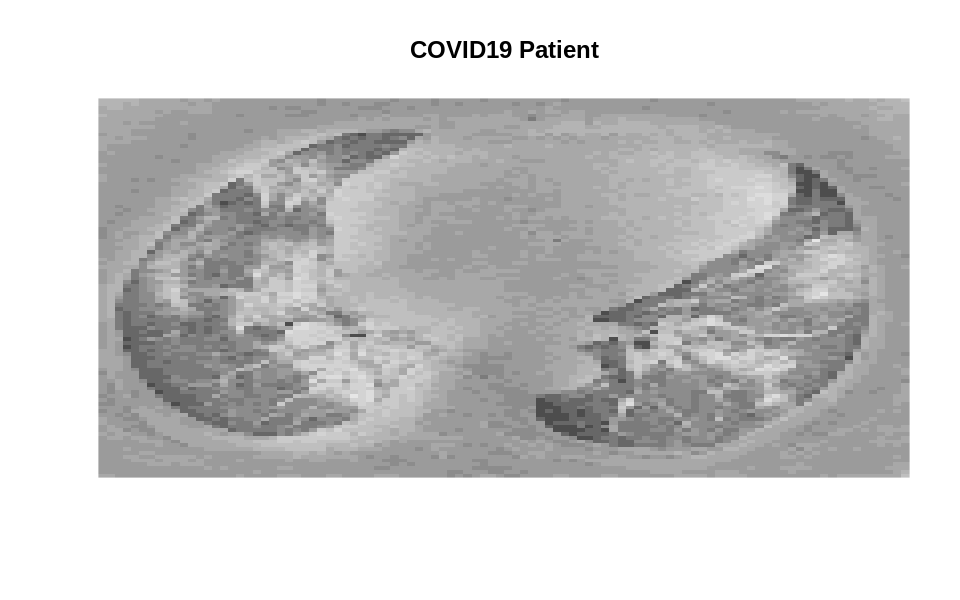

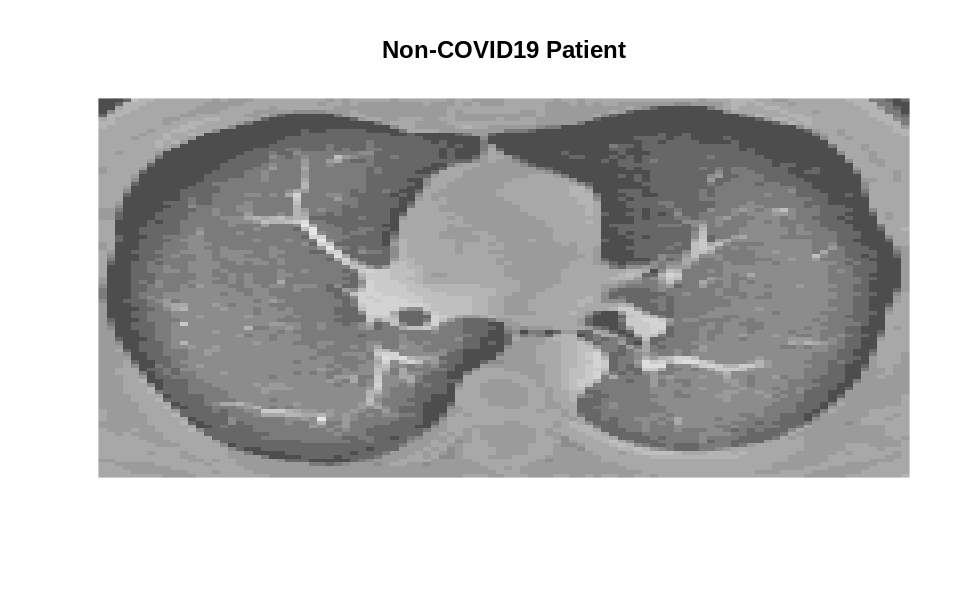

In [ ]:
image(t(apply(covid[10,,],2,rev)), main = "COVID19 Patient",
      axes=FALSE, col = gray.colors(12))
image(t(apply(ncovid[10,,],2,rev)), main = "Non-COVID19 Patient",
      axes=FALSE, col = gray.colors(12))

Now we put all the data together and shuffle it.

In [ ]:
df <- rbind(cbind(covid_reshaped, 1), # 1 = covid
            cbind(ncovid_reshaped, 0)) # 0 = no covid
set.seed(1234)
shuffle <- sample(nrow(df), replace = F)
df <- df[shuffle, ]

ERROR: Error in eval(expr, envir, enclos): object 'covid_reshaped' not found


Split the data into train and test

In [ ]:
set.seed(2022)
split <- sample(2, nrow(df), replace = T, prob = c(0.7, 0.2))
train <- df[split == 1,c(1:1000)]
test <- df[split == 2,c(1:1000)]
train_target <- df[split == 1, 10001] # label in training dataset
test_target <- df[split == 2, 10001] # label in testing dataset

ERROR: Error in sample.int(x, size, replace, prob): invalid 'size' argument


In [ ]:
dim(train)
dim(test)

[1] 1927 1000

[1]  554 1000

## Model Building and Trainning

In [ ]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = c(1000)) %>%
  layer_dropout(0.2) %>%
  layer_dense(units = 2, activation = 'softmax')

ERROR: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Sequential name=sequential, built=False> (of type <class 'keras.src.models.sequential.Sequential'>)

In [ ]:
model %>%
  compile(optimizer = 'adam',
          loss = 'binary_crossentropy',
          metrics = c('accuracy'))

Model has ~ 64000 parameters to learn

In [ ]:
summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_1 (Dense)                    (None, 64)                      64064       
 dropout (Dropout)                  (None, 64)                      0           
 dense (Dense)                      (None, 2)                       130         
Total params: 64,194
Trainable params: 64,194
Non-trainable params: 0
________________________________________________________________________________


Now we do the [one hot encoding](https://en.wikipedia.org/wiki/One-hot) of our output variable.

In [ ]:
train_label <- to_categorical(train_target)
test_label <- to_categorical(test_target)

In [ ]:
fit_covid <- model %>%
  fit(x = train,
      y = train_label,
      epochs = 10,
      batch_size = 16,
      verbose = 1,
      validation_split = 0.2)

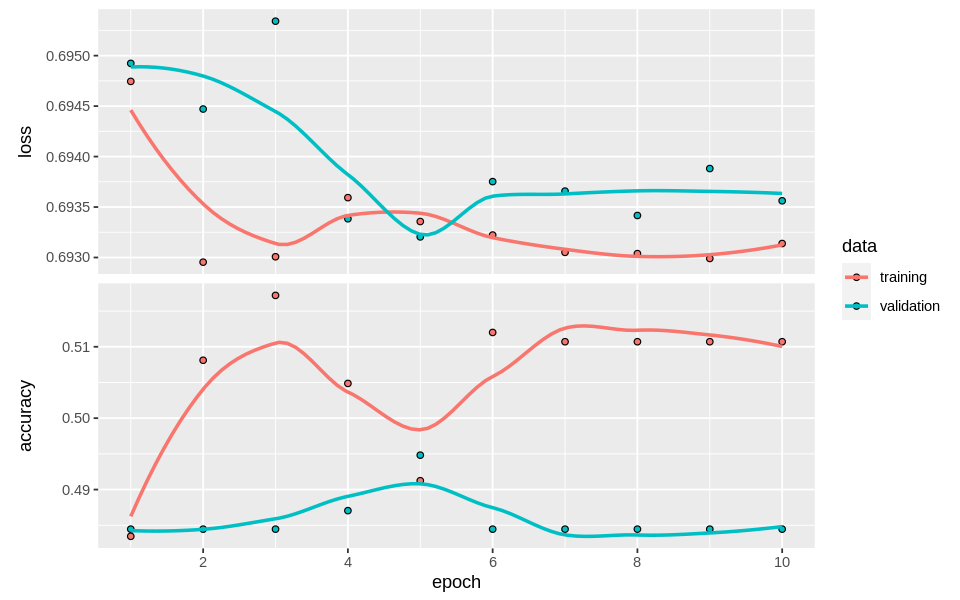

In [ ]:
plot(fit_covid)

## Model Evaluation

In [ ]:
model %>%
  evaluate(test, test_label)

loss  accuracy 
0.6931062 0.5018051

Test our model by doing a prediction on the test partition than build a confusion matrix

In [ ]:
predictions <- model %>% predict(test) %>% k_argmax()
expected_value <- test_label %>% k_argmax()

In [ ]:
# Need to convert data to factor
predictions <- factor(as.array(predictions))
expected_value <- factor(as.array(expected_value))
#Display results in a Confusion Matrix
confusionMatrix(data=predictions, reference = expected_value)

Warning message in confusionMatrix.default(data = predictions, reference = expected_value):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0   0   0
         1 276 278
                                          
               Accuracy : 0.5018          
                 95% CI : (0.4594, 0.5442)
    No Information Rate : 0.5018          
    P-Value [Acc > NIR] : 0.517           
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.5018          
             Prevalence : 0.4982          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                              